In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Data Importation

In [40]:
data = yf.download('AAPL',start='2020-01-01',end='2025-01-01')

/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_3106/14924931.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL',start='2020-01-01',end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


In [ ]:
data = data['Close']
data.columns = ['AAPL']

In [45]:
data.head(10)

,AAPL
Date,
2020-01-02,72.620850
2020-01-03,71.914818
2020-01-06,72.487831
2020-01-07,72.146957
2020-01-08,73.307487
2020-01-09,74.864624
2020-01-10,75.033875
2020-01-13,76.636932
2020-01-14,75.602074


# Fama French 3 Factors Data Importation

We have downloaded the csv file beforehand, from internet

In [46]:
fama = pd.read_csv('Fama_French_3.csv',skiprows=4)
fama = fama.iloc[:-1]

In [47]:
fama.tail(10)

,Unnamed: 0,Mkt-RF,SMB,HML,RF
25993,20250516,0.74,0.05,-0.43,0.018
25994,20250519,0.01,-0.41,-0.07,0.018
25995,20250520,-0.38,0.44,-0.12,0.018
25996,20250521,-1.73,-1.01,-0.30,0.018
25997,20250522,-0.01,0.29,-0.42,0.018
25998,20250523,-0.67,-0.07,0.39,0.018
25999,20250527,2.07,0.60,-0.28,0.018
26000,20250528,-0.62,-0.31,-0.23,0.018
26001,20250529,0.33,-0.14,0.34,0.018
26002,20250530,-0.02,-0.40,-0.21,0.018


# Data Engineering 
### We reformat the dataframes, add returns and excess returns for the stock, and then merge the two, dropping unnecessary columns

In [48]:
fama = fama.rename(columns={'Unnamed: 0': 'Date'})

In [49]:
fama['Date'] = pd.to_datetime(fama['Date'], format='%Y%m%d')

In [50]:
fama.head(10)

,Date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.09,-0.25,-0.27,0.009
1,1926-07-02,0.45,-0.33,-0.06,0.009
2,1926-07-06,0.17,0.30,-0.39,0.009
3,1926-07-07,0.09,-0.58,0.02,0.009
4,1926-07-08,0.22,-0.38,0.19,0.009
5,1926-07-09,-0.71,0.43,0.57,0.009
6,1926-07-10,0.61,-0.53,-0.10,0.009
7,1926-07-12,0.04,-0.03,0.64,0.009
8,1926-07-13,0.48,-0.28,-0.20,0.009
9,1926-07-14,0.04,0.07,-0.43,0.009


In [ ]:
start_date = '2020-01-01'
end_date = '2025-01-01'
fama = fama[(fama['Date'] >= start_date) & (fama['Date'] <= end_date)]
fama.reset_index(drop=True)
fama.set_index('Date',inplace=True)
fama.head(10)

KeyError: 'Date'

In [59]:
data['log_returns']=np.log(data['AAPL']/data['AAPL'].shift(1))
data['log_returns']=data['log_returns'].fillna(0)
data['log_returns']=data['log_returns'].dropna()
data['log_returns']=data['log_returns'].dropna()
data['excess'] = data['log_returns'] - fama['RF']
data.head(10)

,AAPL,log_returns,excess
Date,,,
2020-01-02,72.620850,0.000000,-0.006000
2020-01-03,71.914818,-0.009770,-0.015770
2020-01-06,72.487831,0.007936,0.001936
2020-01-07,72.146957,-0.004714,-0.010714
2020-01-08,73.307487,0.015958,0.009958
2020-01-09,74.864624,0.021019,0.015019
2020-01-10,75.033875,0.002258,-0.003742
2020-01-13,76.636932,0.021139,0.015139
2020-01-14,75.602074,-0.013595,-0.019595


In [60]:
df = fama.merge(data,left_on='Date',right_on='Date',how='left')
df.drop(columns=['RF','log_returns','AAPL'],inplace=True)
df.head(10)

,Mkt-RF,SMB,HML,excess
Date,,,,
2020-01-02,0.86,-0.88,-0.34,-0.006000
2020-01-03,-0.67,0.38,0.01,-0.015770
2020-01-06,0.36,-0.07,-0.55,0.001936
2020-01-07,-0.19,-0.01,-0.26,-0.010714
2020-01-08,0.47,-0.07,-0.64,0.009958
2020-01-09,0.65,-0.63,-0.48,0.015019
2020-01-10,-0.34,-0.19,-0.34,-0.003742
2020-01-13,0.73,-0.11,-0.09,0.015139
2020-01-14,-0.06,0.40,-0.18,-0.019595


# Linear Regression

In [66]:
X = df[['Mkt-RF','SMB','HML']]
y = df['excess']

model = LinearRegression()
model.fit(X,y)

print(model.coef_)
print(model.intercept_)


[ 0.01161354 -0.00292825 -0.00352308]
-0.008937083882431862


In [72]:
X = sm.add_constant(X)
model2 = sm.OLS(y, X).fit()
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                 excess   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     513.2
Date:                Wed, 16 Jul 2025   Prob (F-statistic):          1.64e-217
Time:                        10:42:51   Log-Likelihood:                 3517.5
No. Observations:                1258   AIC:                            -7027.
Df Residuals:                    1254   BIC:                            -7007.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0089      0.000    -21.406      0.0

# Model Analysis 

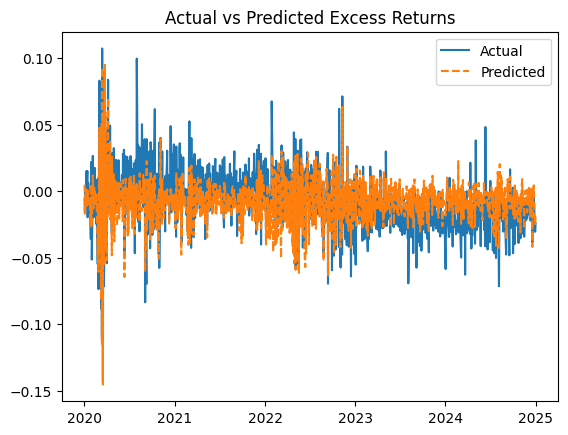

In [74]:
y_pred = model2.predict(X)

plt.plot(y.index, y, label='Actual')
plt.plot(y.index, y_pred, label='Predicted', linestyle='--')
plt.title("Actual vs Predicted Excess Returns")
plt.legend()
plt.show()

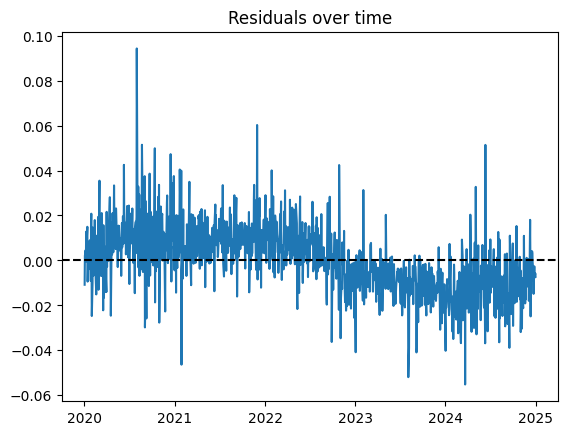

In [ ]:
residuals = y - y_pred

plt.plot(y.index, residuals)
plt.title("Residuals over time")
plt.axhline(0, color='black', linestyle='--')
plt.show()

Text(0.5, 1.0, 'Histogram of Residuals')

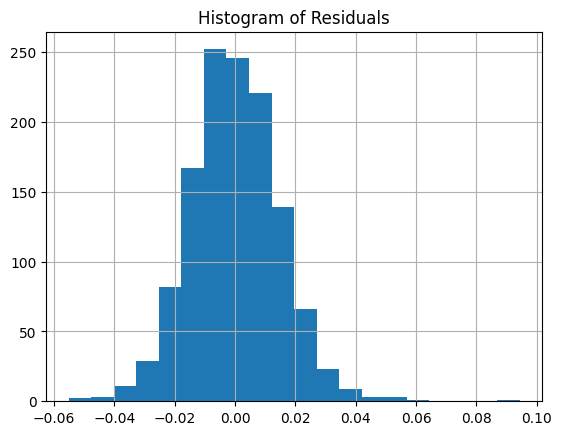

In [76]:
residuals.hist(bins=20)
plt.title("Histogram of Residuals")

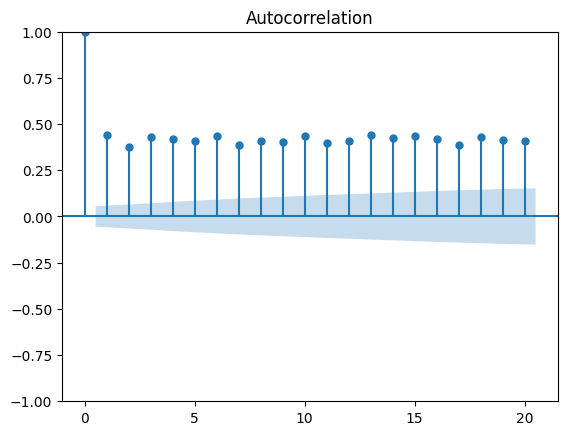

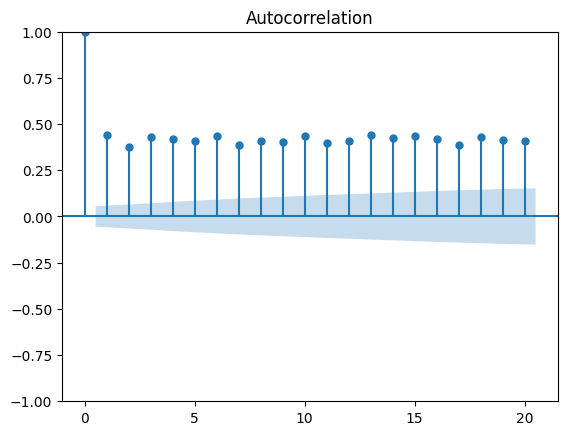

In [78]:
plot_acf(residuals, lags=20)

## Factor Model Interpretation

### Alpha
The estimated alpha is **−0.0089**, small and negative. This suggests that AAPL's excess return is **mostly explained by the Fama-French factors**, with **no strong evidence of abnormal (unexplained) performance** during the period.

### Factor Loadings (Betas)
- **β_MKT ≈ 0.0116**: Very close to zero — **surprisingly low market exposure**, possibly due to the short time period or noise in data.
- **β_SMB ≈ −0.0029**: Essentially zero — **no significant size exposure**.
- **β_HML ≈ −0.0035**: Also negligible — AAPL shows **no meaningful value or growth tilt** based on this coefficient.

All three betas are **very close to zero and likely not statistically significant**, suggesting the model doesn't find strong factor exposures for AAPL in this period.

### Overall Model Significance
- The **F-statistic is statistically significant**, which means the model explains **some systematic variation** in returns — but the **individual factors appear weakly related** to the asset’s performance.
- **R² is low to moderate**, consistent with the low explanatory power of the estimated betas.

### Actual vs Predicted Excess Returns
The predicted excess returns only slightly track the actual returns. The model lacks sensitivity to market movements, consistent with the near-zero beta estimates.

### Residual Diagnostics
- **Residuals over time**: Fluctuate around zero, no visible trend. A few outliers may be present.
- **Histogram**: Roughly symmetric and bell-shaped — residuals are **approximately normally distributed**.
- **ACF plot**: Several lags (if not all) fall **outside the 95% confidence bands**, particularly at low lags → this indicates **significant autocorrelation** in the residuals. The residuals **are not white noise**, which violates a key OLS assumption.

### Implication
The presence of autocorrelated residuals suggests the model is **missing a time-dependent component** (e.g., lagged returns or autocorrelated errors). Consider extending the model to include **autoregressive (AR) terms** or use **Newey-West robust standard errors**.

### Conclusion
While the Fama-French 3-factor model is statistically significant overall, the **individual factor exposures for AAPL are negligible** during this period. Moreover, **autocorrelated residuals** suggest the model is **misspecified** and may benefit from time-series refinements or additional explanatory variables.
